In [1]:
import csv
import json
import time
import sys
import re
import pandas as pd
from urllib import request, parse, robotparser, error
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud
from scipy.stats import gaussian_kde
from pathlib import Path
import backboning
from backboning import high_salience_skeleton



# Preparing Data 

### Load data

Loading the scraped data, which is stored in a csv file from the scraping process. See the notebook Data_scarping.ipynb.

In [2]:
# Scraped data
data = pd.read_csv("bbc_food_recipes.csv")

# Load food list from Excel
food_list = pd.read_excel("Frida_Dataset_May2025.xlsx", sheet_name="Data_Table", skiprows=1)

food_list_units = food_list.iloc[0]

# Remove rows 0 and 1, reset index, and rename first three columns
food_list = (food_list.drop(index=[0, 1])
             .reset_index(drop=True)
             .rename(columns={food_list.columns[0]: "Food_Danish",
                            food_list.columns[1]: "Food_English",
                            food_list.columns[2]: "Food_ID"}))

# Extract first part before comma from Food_English and get unique values
single_food_list = list(set(item.split(',')[0] for item in food_list['Food_English']))

# Add additional ingredients
single_food_list.extend(['mushrooms', 'white wine', 'red wine', 'caster sugar', 
                        'chicken stock', 'vegetable stock', 'beef stock', 'basil', 
                        'oregano', 'thyme', 'rosemary', 'parmasan', 'mozzarella'])

### Extract clean list of ingredients
Cleaning the data and generating of a new column for cleaned ingredients. Common words and units are filtered out.

In [3]:
def extract_ingredients(ingredient_string, food_list):
    """Extract and clean ingredients from a string, matching against a food list."""
    
    # Normalize string
    text = ingredient_string.replace(',', '').replace(' || ', ',').lower()
    ingredients = text.split(',')
    
    # Helper function to remove plural endings
    def singularize(word):
        if word.endswith('ies'):
            return word[:-3] + 'y'
        elif word == 'sausages' or word == 'sausage':
            return 'sausage'
        elif word.endswith('es'):
            return word[:-2]
        elif word.endswith('s'):
            return word[:-1]

        return word
    
    # Words to combine with previous word
    combiners = {'oil', 'sugar', 'wine', 'purée', 'stock'}
    
    # Words to filter out
    units = {'kg', 'g', 'mg', 'l', 'ml', 'tsp', 'tbsp', 'cup', 'cups', 'oz', 'lb', 
             'pint', 'quart', 'dash', 'pinch', 'clove', 'cloves', 'slice', 'slices', 
             'can', 'cans', 'bunch', 'bunches'}
    common = {'of', 'fresh', 'chopped', 'diced', 'minced', 'ground', 'large', 'small', 
              'medium', 'to', 'taste', 'and', 'x', 'piece', 'pieces', 'packet', 
              'packets', 'bottle', 'bottles', 'jar', 'jars', 'bag', 'bags'}
    
    # Create lowercase version of food_list once
    food_list_lower = {f.lower() for f in food_list}
    
    clean_list = []
    
    for ingredient in ingredients:
        words = [singularize(w) for w in ingredient.split()]
        
        # Combine special words with previous word
        combined = []
        for i, word in enumerate(words):
            if word in combiners and combined:
                combined[-1] = f"{combined[-1]} {word}"
            elif word:
                combined.append(word)
        
        # Filter out units and common words
        filtered = [w for w in combined if w not in units and w not in common]
        
        # Match against food list
        for word in filtered:
            word = word.replace('tomato purée', 'tomato puree')
            if word in food_list_lower:
                clean_list.append(word)
    
    return list(set(clean_list))

In [4]:
# Make new column with cleaned ingredients
clean_ingredients = []

for ing in data['ingredients']:
    clean_list = extract_ingredients(ing, single_food_list)
    clean_ingredients.append(clean_list)

data['clean_ingredients'] = clean_ingredients

In [5]:
## Remove certain ingredients from the list
remove_ingredients = ['salt', 'pepper']
data['final_ingredients'] = data['clean_ingredients'].apply(
    lambda lst: [item for item in lst if item not in remove_ingredients]
)

In [6]:
## Basic statistics
print(f'Total recipes scraped: {len(data)}')
print(f'Total unique ingredients: {len(set(item for sublist in data["final_ingredients"] for item in sublist))}')

Total recipes scraped: 445
Total unique ingredients: 152


In [7]:
## Most common ingredients
all_ingredients = [item for sublist in data['final_ingredients'] for item in sublist]
ingredient_counts = Counter(all_ingredients)
print(f'The 10 most common ingredients are: {ingredient_counts.most_common(10)}')
print(f'The 10 least common ingredients are: {ingredient_counts.most_common()[-10:]}')

The 10 most common ingredients are: [('garlic', 207), ('onion', 206), ('olive oil', 165), ('butter', 150), ('egg', 146), ('tomato', 114), ('chicken', 111), ('lemon', 96), ('coriander', 94), ('sauce', 93)]
The 10 least common ingredients are: [('soup', 1), ('vermouth', 1), ('vodka', 1), ('hake', 1), ('turnip', 1), ('shrimp', 1), ('bouillon', 1), ('duck', 1), ('watermelon', 1), ('tea', 1)]


### Initial exploration of data

To get insights from the data, and what to include in the analysis.

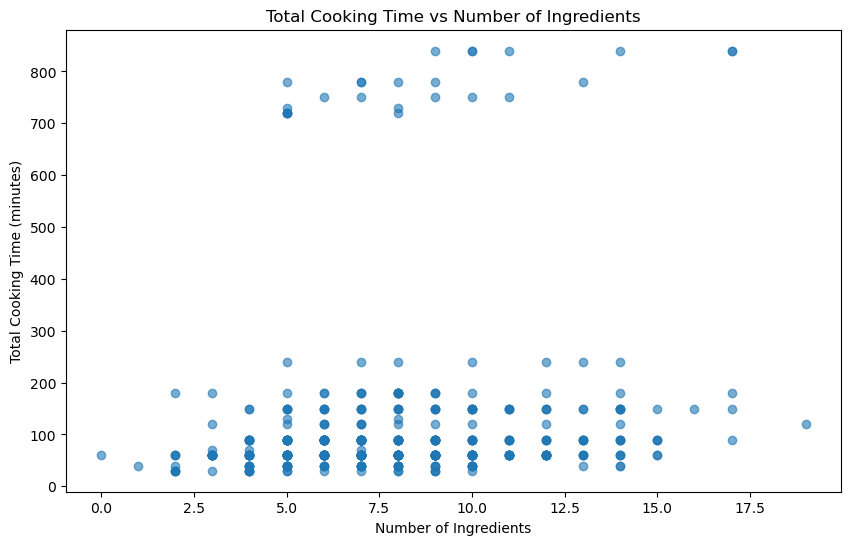

In [8]:
## Total time vs number of ingredients
plt.figure(figsize=(10, 6))
plt.scatter(data['final_ingredients'].apply(len), data['total_time_min'], alpha=0.6)
plt.title('Total Cooking Time vs Number of Ingredients')
plt.xlabel('Number of Ingredients')
plt.ylabel('Total Cooking Time (minutes)')
plt.show()

# Network

Crating the recipe network, where each recipe is represented by a node and edges are the shared ingredients. The edges are weighted due to the number of shared ingredients. Moreover, recipes with less than 3 shared ingredients are not linked.

In [9]:
## Create graph with recipes as nodes and ingredients as edges add weight based on number of shared ingredients
G_recipes = nx.Graph()
for idx, row in data.iterrows():
    G_recipes.add_node(row['title'],ratingValue=row['ratingValue'],
        ratingCount=row['ratingCount'])

for idx1, row1 in data.iterrows():
    for idx2, row2 in data.iterrows():
        if idx1 != idx2:
            common_ingredients = set(row1['final_ingredients']).intersection(set(row2['final_ingredients']))
            
            # Add edge if 3 or more ingredients are shared amd add weight
            if len(common_ingredients) >= 3:
                if G_recipes.has_edge(row1['title'], row2['title']):
                    G_recipes[row1['title']][row2['title']]['weight'] += len(common_ingredients)
                else:
                    G_recipes.add_edge(row1['title'], row2['title'], weight=len(common_ingredients),shared_ingredients=list(common_ingredients))

print(f'The number of nodes in the recipe graph is: {G_recipes.number_of_nodes()}')
print(f'The number of edges in the recipe graph is: {G_recipes.number_of_edges()}')

The number of nodes in the recipe graph is: 445
The number of edges in the recipe graph is: 19469


In [10]:
## Find recipe containing specific ingredients
target_ingredients = {'chocolate', 'apple'}

matching_recipes = []
for idx, row in data.iterrows():
    if target_ingredients.issubset(set(row['final_ingredients'])):
        matching_recipes.append((row['title'], row['url']))

print(f"Recipes containing {target_ingredients}:")
for title, url in matching_recipes:
    print(f"- {title}: {url}")

Recipes containing {'chocolate', 'apple'}:
- Gluten-free cupcakes with tahini icing: https://www.bbc.co.uk/food/recipes/buckwheat_and_butternut_60078


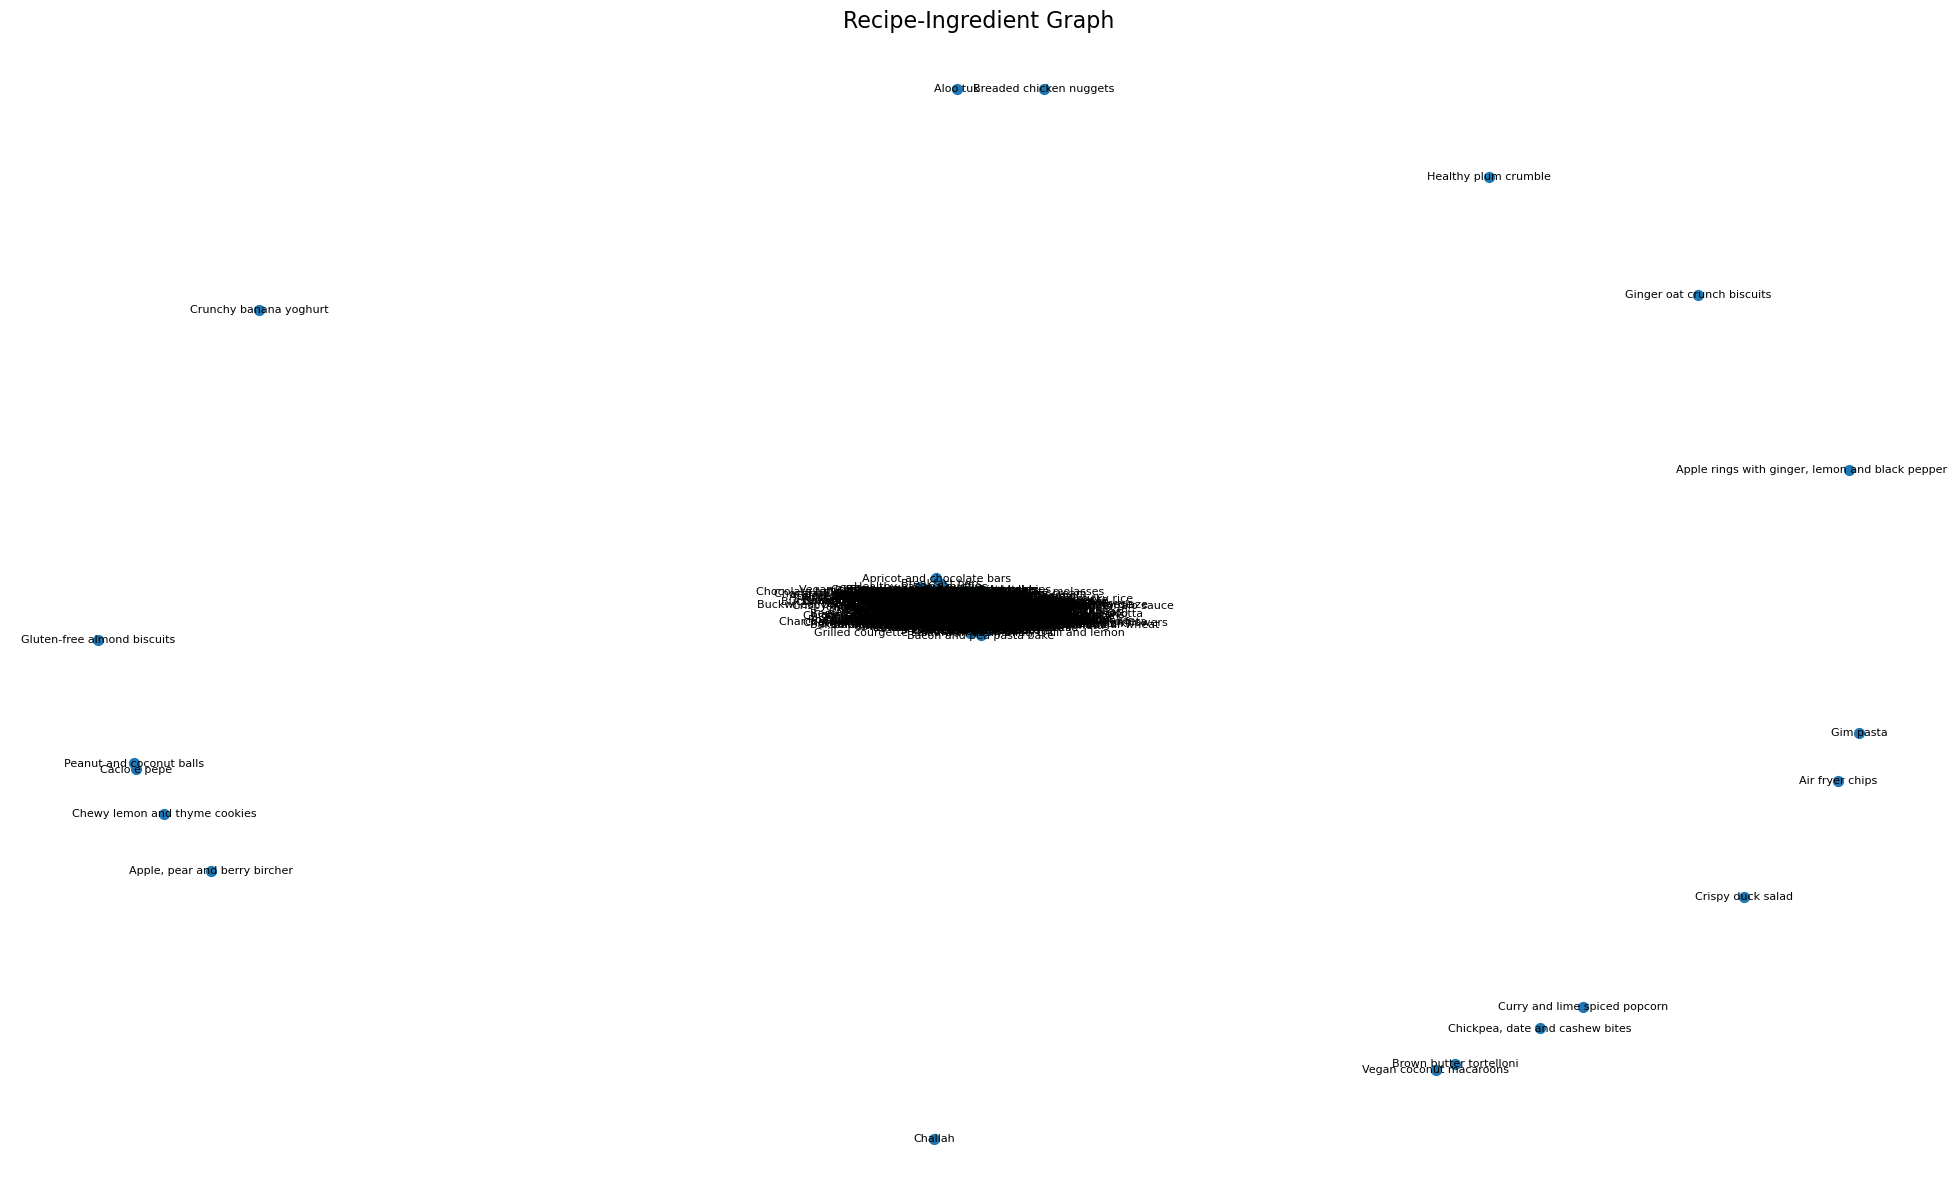

In [11]:
plt.figure(figsize=(25, 15))
pos = nx.forceatlas2_layout(G_recipes, max_iter=2000)

# Draw nodes and labels
nx.draw_networkx_nodes(G_recipes, pos, node_size=50)
nx.draw_networkx_labels(G_recipes, pos, font_size=8)

# Compute edge widths based on weight (but scaled down)
edge_widths = np.array([d['weight'] for _, _, d in G_recipes.edges(data=True)])
edge_widths = edge_widths / edge_widths.max() * 2  # normalize to max width ~2

# Draw edges with transparency and lighter color
nx.draw_networkx_edges(
    G_recipes,
    pos,
    width=edge_widths,
    edge_color="gray",   
    alpha=0.3             
)

plt.title("Recipe-Ingredient Graph", fontsize=16)
plt.axis("off")
plt.show()


## Network statistics

In [12]:
## Degree distributions
degree_sequence = [d for n, d in G_recipes.degree()]
degree_count = Counter(degree_sequence)
deg, cnt = zip(*sorted(degree_count.items()))

mean_degree = np.mean(degree_sequence)
median_degree = np.median(degree_sequence)
print(f'Mean degree: {mean_degree}')
print(f'Median degree: {median_degree}\n')

# Top 5 recipes sharing most ingredients
top_5_recipes = sorted(G_recipes.degree(), key=lambda x: x[1], reverse=True)[:5]
for recipe, degree in top_5_recipes:
    print(f'{recipe}: {degree}')

Mean degree: 87.50112359550562
Median degree: 77.0

Breakfast burrito: 305
Cheese and onion quiche: 234
Beetroot and goats’ cheese risotto: 232
Vegan burgers: 229
Caribbean chicken with rice and peas: 222


In [13]:
## Print all elements of a specific recipe 
for col in ['ingredients', 'clean_ingredients', 'final_ingredients']:
    print(f"\n{col} for 'Breakfast burrito':")
    print( data[data['title'] == 'Breakfast burrito'][col].values[0] )

len(data[data['title'] == 'Breakfast burrito']['final_ingredients'].values[0])



ingredients for 'Breakfast burrito':
60g/2¼oz mature cheddar, grated || salt and freshly ground black pepper || 100g/3½oz dried black beans, soaked overnight in cold water || 1 onion, halved || 1 dried ancho chilli || 2 garlic cloves, finely chopped || 45g/1¾oz lard || 175g/6oz plain flour, plus extra for dusting || 35g/1¼oz cornmeal or polenta || 1 tsp baking powder || 150ml/5fl oz warm water || 2 large tomatoes, flesh finely chopped, juice and seeds drained || ½ tsp caster sugar || ½ lime, juice only || 1½ large avocados, roughly chopped || 1 large red hot chilli, finely chopped || 2 tsp chopped fresh coriander || ½ lime, juice only || 1 tsp olive oil || 2 sun-dried tomatoes, finely chopped || 1 jalapeño chilli, finely chopped || 100ml/3½fl oz soured cream || 1½ tsp olive oil || 200g/7oz spicy cooking chorizo, roughly chopped || 5 chestnut mushrooms, roughly chopped || 2–3 tbsp chipotle sauce || 40g/1½oz butter || 4 large free-range eggs

clean_ingredients for 'Breakfast burrito':
[

17

### Degree distributions

Next, we want to investigate if the network have random or scale-free properties by comparing degree distributions

In [14]:
## Degree distributions

# Compute degrees
degrees = [d for n, d in G_recipes.degree()]

# Generate multiple random networks and aggregate degrees
n_samples = 50
random_degrees_all = []
for _ in range(n_samples):
    Gr_temp = nx.gnm_random_graph(G_recipes.number_of_nodes(), G_recipes.number_of_edges())
    random_degrees_all.extend([d for n, d in Gr_temp.degree()])

# Generate multiple scale-free networks and aggregate degrees
avg_degree = int(2 * G_recipes.number_of_edges() / G_recipes.number_of_nodes())
m = max(1, avg_degree // 2)

scale_degrees_all = []
for _ in range(n_samples):
    Gs_temp = nx.barabasi_albert_graph(G_recipes.number_of_nodes(), m=m)
    scale_degrees_all.extend([d for n, d in Gs_temp.degree()])

# KDE for random and scale-free networks
max_degree = max(max(degrees), max(random_degrees_all), max(scale_degrees_all))
x_range = np.linspace(0, max_degree, 300)

kde_random = gaussian_kde(random_degrees_all)
kde_scale = gaussian_kde(scale_degrees_all)
random_pdf = kde_random(x_range)
scale_pdf = kde_scale(x_range)

# Histogram parameters with explicit bin edges for integer degrees
min_degree = min(degrees)
max_degree = max(degrees)
bin_edges = np.arange(min_degree, max_degree + 2) - 0.5  # Bins centered on integers
num_bins = len(bin_edges) - 1
bin_width = 1  # Each bin is exactly 1 degree wide

n_samples = len(degrees)

# Scale KDE to match histogram counts
random_counts = random_pdf * n_samples * bin_width
scale_counts = scale_pdf * n_samples * bin_width

# Plot
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=degrees,
    xbins=dict(
        start=bin_edges[0],
        end=bin_edges[-1],
        size=1  # Bin width of 1 degree
    ),
    marker_color='steelblue',
    marker_line_color='white',
    marker_line_width=1,
    opacity=0.6,
    name="Recipe network"
))

# --- Mean & median vertical lines ---
fig.add_vline(x=mean_degree, line_dash="dash", line_color="red",
              annotation_text="Mean", annotation_position="top right")

fig.add_vline(x=median_degree, line_dash="dot", line_color="green",
              annotation_text="Median", annotation_position="top left")

fig.add_trace(go.Scatter(
    x=x_range,
    y=random_counts,
    mode='lines',
    name="Random network (50 nets)",
    line=dict(width=3, color='seagreen')
))

fig.add_trace(go.Scatter(
    x=x_range,
    y=scale_counts,
    mode='lines',
    name="Scale-free network (50 nets)",
    line=dict(width=3, color='darkorange')
))

fig.update_layout(
    width=900, height=500,
    title_text="Degree Distribution",
    xaxis_title="Degree",
    yaxis_title="Count",
    template="plotly_white",
    legend=dict(x=0.8, y=0.95)
)

fig.show()

what can we conclude from this: it does not look like the degree distr. of the recipe network follow what we could assume from either a random nor scale-free network. use chapter 3 to explain how this knowledge has an impact on when new recipes (nodes) are added to the network (a new recipe is posted on BBC goodfood)

In [15]:
# map degree to data
degree_map = dict(G_recipes.degree())
data['degree'] = data['title'].map(degree_map)

In [16]:
# remove isolated nodes
isolated_nodes = list(nx.isolates(G_recipes))
G_recipes.remove_nodes_from(isolated_nodes)

print(f'The number of nodes in the recipe graph after removing isolated nodes is: {G_recipes.number_of_nodes()}')

The number of nodes in the recipe graph after removing isolated nodes is: 426


In [17]:
# Print subset of edges with weights
for u, v, d in list(G_recipes.edges(data=True))[-10:]:
    print(f"{u} - {v}: {d['weight']}")

Air fryer harissa chicken with herby couscous - Bún chả inspired noodle bowl: 6
Air fryer harissa chicken with herby couscous - Easy chicken and chorizo rice: 6
Air fryer harissa chicken with herby couscous - Chicken fajita bowl: 6
Air fryer harissa chicken with herby couscous - Creamy mushroom chicken: 8
Bún chả inspired noodle bowl - Easy chicken and chorizo rice: 8
Bún chả inspired noodle bowl - Chicken fajita bowl: 10
Bún chả inspired noodle bowl - Creamy mushroom chicken: 6
Easy chicken and chorizo rice - Chicken fajita bowl: 8
Easy chicken and chorizo rice - Creamy mushroom chicken: 10
Chicken fajita bowl - Creamy mushroom chicken: 6


### Centrality
Calculate the different centralities to get insight of the network representation of the recipes and their ingredients.

In [18]:
## Please calculate the 5 most central nodes according to degree centrality, betweenness centrality, and eigenvector centrality.
degree_centrality = nx.degree_centrality(G_recipes)
betweenness_centrality = nx.betweenness_centrality(G_recipes)
eigenvector_centrality = nx.eigenvector_centrality(G_recipes, max_iter=1000)

## Visualizing the betweenness centrality of nodes vs degree centrality and the eigenvector centrality in a subplot using plotly
fig = make_subplots(rows=1, cols=2, subplot_titles=('Degree vs Betweenness Centrality', 'Degree vs Eigenvector Centrality'))
fig.add_trace(go.Scatter(x=list(betweenness_centrality.values()), y=list(degree_centrality.values()),
                         mode='markers', name='Degree Centrality vs Betweenness Centrality',
                         marker=dict(color='blue', size=8, opacity=0.6)),
              row=1, col=1)
fig.add_trace(go.Scatter(x=list(eigenvector_centrality.values()), y=list(degree_centrality.values()),
                         mode='markers', name='Degree Centrality vs Eigenvector Centrality',
                         marker=dict(color='orange', size=8, opacity=0.6)),
                row=1, col=2)
fig.update_xaxes(title_text='Betweenness Centrality', row=1, col=1) #, type='log')
fig.update_yaxes(title_text='Degree Centrality', row=1, col=1) #, type='log')
fig.update_xaxes(title_text='Eigenvector Centrality', row=1, col=2) #, type='log')
fig.update_yaxes(title_text='Degree Centrality', row=1, col=2) #, type='log')
fig.update_layout(title_text='Centrality Measures Comparison', showlegend=False, 
                  width=1200, height=500)
fig.show()

### Assortativity

In [19]:
# Compute degree assortativity
r = nx.degree_assortativity_coefficient(G_recipes)
print(f"Degree assortativity: {r:.4f}")

# Compute assortativity
r = nx.attribute_assortativity_coefficient(G_recipes, "ratingValue")
print(f"Assortativity (ratingValue): {r:.5f}")

# Compute assortativity
r = nx.attribute_assortativity_coefficient(G_recipes, "ratingCount")
print(f"Assortativity (ratingCount): {r:.4f}")

Degree assortativity: 0.0720
Assortativity (ratingValue): -0.00344
Assortativity (ratingCount): -0.0023


The degree assortativity of the network is close to zero. This indicates that there is little or no correlation between highly connected nodes being linked to other highly connected nodes. that is, if a recipe shares ingredients with many other recipes, it does not mean that these recipes also are linked to many. likewise the other way aroud

Similarly, the assortativity based on rating value and rating count is slightly negative but still very close to zero. This shows no meaningful tendency for recipes with similar ratings or similar numbers of ratings to share ingredients with each other. If assortativity in these attributes had been high, it would suggest that ingredient choice influences these recipe characteristics. Instead, the near-zero values imply that ingredient overlap does not systematically relate to how highly a recipe is rated or how many users chose to rate it.


Overall, the network shows no strong assortative or disassortative patterns, implying that connections are largely random with respect to both degree and content length.


### Backbone

We visualize the backbone of the network using different methods such as disparity filter and HSS

In [20]:
# Network 1: The recipe network (Giant Connected Component) but with edge weights proportional to the edge betweenness centrality 
# (renormalize so that the lowest weight is equal to 1 and the highest weight is equal to 100).
G1 = G_recipes.copy()
bet_centrality = nx.edge_betweenness_centrality(G1)
max_eb = max(bet_centrality.values())
min_eb = min(bet_centrality.values())

for u, v in G1.edges():
    eb = bet_centrality[(u, v)]
    # Normalize to range [1, 100]
    weight = 1 + (eb - min_eb) / (max_eb - min_eb) * 99
    G1[u][v]['weight'] = weight

# Network 2: edge weights proportional to 1/(edge weight in Weighted Network 1).
G2 = G1.copy()
for u, v in G2.edges():
    weight = G1[u][v]['weight']
    G2[u][v]['weight'] = 1 / weight if weight > 0 else 0

In [21]:
# Network 3, made with help from LLM as allowed in the exercise instructions
rows = []
for u, v, edge_data in G2.edges(data=True):
    cost = float(edge_data.get("weight", 1.0))
    if cost <= 0:             # avoid zero/negative costs
        cost = 1e-9
    rows.append((u, v, cost))

table = pd.DataFrame(rows, columns=["src", "trg", "nij"])  # HSS expects a weight column; name 'nij' is fine

# Run HSS (aggregate undirected)
hss_df = high_salience_skeleton(table, undirected=True, return_self_loops=False)

# Inspect distribution & pick a data-driven threshold
scores = hss_df["score"].to_numpy()

# Keep the top 10% by salience, but never fewer than 1 edge
pct = 0.90
thr = np.quantile(scores, pct) if len(scores) > 10 else np.max(scores)
# If that's still too strict (all below thr due to ties), relax progressively
if (scores >= thr).sum() == 0:
    for p in (0.80, 0.70, 0.60, 0.50, 0.40, 0.30):
        thr = np.quantile(scores, p)
        if (scores >= thr).sum() > 0:
            break

keep = hss_df[hss_df["score"] >= thr]

# Build G3, preserving original distances and adding salience
G3 = nx.Graph()
G3.add_nodes_from(G2.nodes(data=True))

for _, row in keep.iterrows():
    u, v = row["src"], row["trg"]
    sal = float(row["score"])
    # Grab original attributes in either orientation
    data_uv = G2.get_edge_data(u, v)
    if data_uv is None and G2.is_directed():
        data_uv = G2.get_edge_data(v, u)
    data_back = dict(data_uv) if data_uv else {}
    data_back["salience"] = sal
    G3.add_edge(u, v, **data_back)
    
print(
    f"G3: {G3.number_of_nodes()} nodes, {G3.number_of_edges()} edges "
    f"(threshold={thr:.3f}, kept={len(keep)}/{len(hss_df)} ~ {len(keep)/max(1,len(hss_df)):.1%})")

Calculating HSS score...


G3: 426 nodes, 1961 edges (threshold=0.297, kept=1961/19469 ~ 10.1%)


In [22]:
# Get backboning to work correctly with pandas 2.x
bb_path = Path(r"backboning.py")

src = bb_path.read_text(encoding="utf-8")

# Replace old .drop("col", 1) with .drop(columns=["col"])
src = re.sub(r'\.drop\(\s*"edge"\s*,\s*1\s*\)', '.drop(columns=["edge"])', src)
src = re.sub(r'\.drop\(\s*"score_min"\s*,\s*1\s*\)', '.drop(columns=["score_min"])', src)
src = re.sub(r'\.drop\(\s*"variance_max"\s*,\s*1\s*\)', '.drop(columns=["variance_max"])', src)

bb_path.write_text(src, encoding="utf-8")
print("Patched backboning.py for pandas 2.x compatibility.")

Patched backboning.py for pandas 2.x compatibility.


In [23]:
def disparity_backbone(G, alpha=0.1, top_q=0.95, undirected=True):
    """
    Returns the largest-component backbone of G using the disparity filter.
    alpha: significance threshold for alpha/p columns (loosen to e.g. 0.15 if too sparse)
    top_q: keep top quantile if the filter returns 'score' (e.g., 0.9 keeps top 10%)
    """
    # Build (src, trg, nij) table
    tbl = pd.DataFrame(
        ((u, v, float(d.get("weight", 1.0))) for u, v, d in G.edges(data=True)),
        columns=["src", "trg", "nij"],
    )
    df = backboning.disparity_filter(tbl, undirected=undirected)

    # Pick significance column and keep edges
    sig = next((c for c in ("alpha", "p", "score") if c in df.columns), None)
    if sig is None:
        raise ValueError(f"No significance column found. Got: {df.columns.tolist()}")

    if sig in ("alpha", "p"):
        keep = df.loc[df[sig].le(alpha), ["src", "trg", "nij"]]
    else:
        thr = df[sig].quantile(top_q)
        keep = df.loc[df[sig].ge(thr), ["src", "trg", "nij"]]

    # Build backbone graph and keep the largest connected component (if any)
    B = nx.from_pandas_edgelist(keep, "src", "trg", edge_attr="nij", create_using=nx.Graph())
    if B.number_of_edges():
        B = B.subgraph(max(nx.connected_components(B), key=len)).copy()
    return B, sig

# ---- Plot helper: size by (unweighted) degree, hide isolates ----
def plot_backbone(B, title, sig_label, figsize=(10, 6)):
    if B.number_of_nodes() == 0:
        print(f"{title}: backbone is empty at current settings.")
        return
    # remove isolates if any (aesthetics)
    B = B.subgraph([n for n in B.nodes if B.degree(n) > 0]).copy()
    pos = nx.forceatlas2_layout(B, max_iter=600)
    deg = dict(B.degree())
    sizes = [10 + 2*deg[n] for n in B.nodes()]  # scale as you wish

    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(B, pos, node_size=sizes, node_color="darkslateblue")
    nx.draw_networkx_edges(B, pos, alpha=0.85, width=1.0, edge_color="gray")
    plt.title(f"{title} (kept by {sig_label})")
    plt.axis("off")
    plt.show()

Calculating DF score...


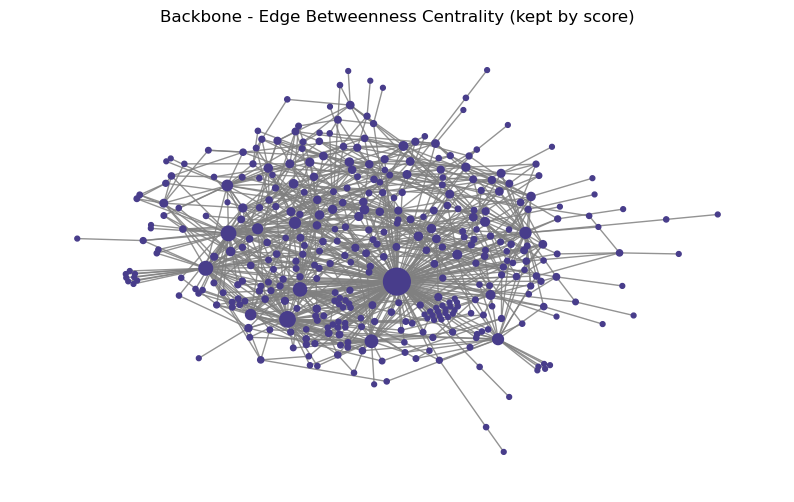

In [24]:
B1, sig1 = disparity_backbone(G1, alpha=0.10, top_q=0.95)
plot_backbone(B1, "Backbone - Edge Betweenness Centrality", sig1)

Calculating DF score...


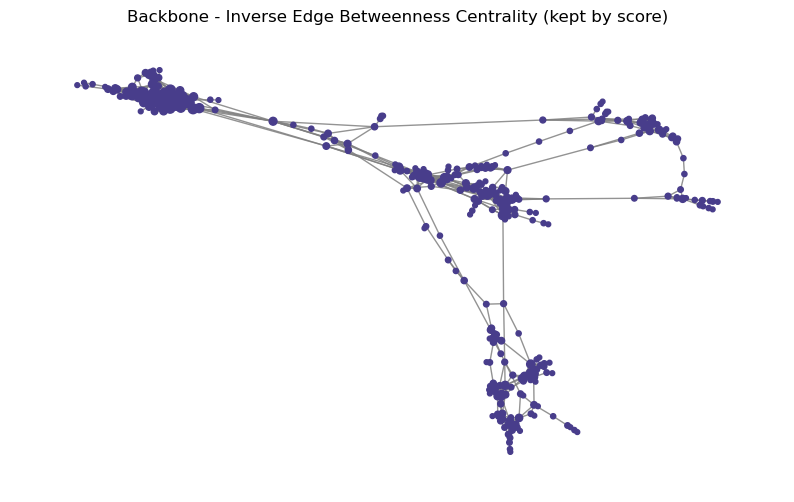

In [25]:
B2, sig2 = disparity_backbone(G2, alpha=0.10, top_q=0.95)
plot_backbone(B2, "Backbone - Inverse Edge Betweenness Centrality", sig2)

Calculating DF score...


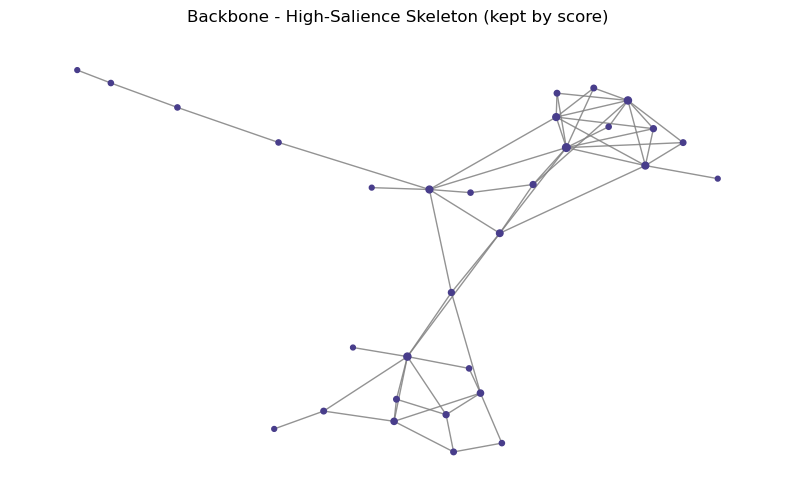

In [26]:
B3, sig3 = disparity_backbone(G3, alpha=0.10, top_q=0.95)
plot_backbone(B3, "Backbone - High-Salience Skeleton", sig3)

## Community detection

### Louvain method

In [27]:
# make community detection on recipe graph
louvainC = nx.community.louvain_communities(G_recipes,seed=42)

print(f"Detected {len(louvainC)} communities using Lovain algorithm.")

# Compute modularity - 2 different approaches
M_louvain = nx.community.modularity(G_recipes, louvainC)

L = G_recipes.number_of_edges()
M_LA = 0

for nodes in louvainC:
    subgraph = G_recipes.subgraph(nodes)
    Lc = subgraph.number_of_edges()
    kc = sum(dict(G_recipes.degree(nodes)).values())
    M_LA += (Lc / L) - (kc / (2*L))**2

print(f"Modularity computed from: {M_LA:.4f}")
print(f"Modularity from NetworkX function: {M_louvain:.4f}")

# print communities
for i, com in enumerate(louvainC):
    print(f"Community {i+1}: {com}")

Detected 4 communities using Lovain algorithm.
Modularity computed from: 0.2436
Modularity from NetworkX function: 0.2554
Community 1: {'Black Forest gâteau', 'Easy ginger loaf cake', 'Dark and sumptuous chocolate cake', 'Ginger and treacle spiced traybake', 'Cheese and onion quiche', 'Chocolate pot with ginger', 'Easy cherry cake', 'Buckwheat pancakes with smoked salmon and citrus cream cheese', 'Coffee and chocolate custard pots', 'Arctic roll', 'Lemon polenta cake', 'Coffee and cardamom cake with pistachio cream', 'Bacon eggy bread', 'Ginger and walnut carrot cake', 'Toffee apple muffins', 'Beetroot seed cake', 'Chocolate ripple cheesecake', 'Battenberg cake', 'Beetroot chocolate cake with cream cheese icing', 'Barmbrack', 'Cookie dough', 'Healthy banana muffins', 'Chocolate and brandy shots', 'Gluten-free banana bread', 'Air fryer cheese toastie', 'Blackberry and cinnamon galette', 'Cheese, potato and onion pie', 'Apricot almond cake with rosewater and cardamom', 'Chocolate mousse'

In [28]:
## 10 main ingredients in each community
for i, community in enumerate(louvainC):
    ingredient_counter = Counter()
    for recipe_title in community:
        recipe_row = data[data['title'] == recipe_title].iloc[0]
        ingredient_counter.update(recipe_row['final_ingredients'])
    
    most_common_ingredients = ingredient_counter.most_common(10)
    print(f"Community {i+1} - Top 10 Ingredients: {most_common_ingredients}")

Community 1 - Top 10 Ingredients: [('egg', 83), ('butter', 77), ('caster sugar', 53), ('milk', 40), ('cream', 39), ('chocolate', 30), ('cocoa', 28), ('almond', 22), ('water', 21), ('lemon', 21)]
Community 2 - Top 10 Ingredients: [('onion', 106), ('garlic', 95), ('coriander', 74), ('sauce', 69), ('chicken', 57), ('rice', 49), ('tomato', 44), ('lime', 38), ('bean', 28), ('egg', 28)]
Community 3 - Top 10 Ingredients: [('olive oil', 128), ('garlic', 98), ('onion', 66), ('tomato', 64), ('lemon', 56), ('chicken', 46), ('parsley', 44), ('cheese', 30), ('butter', 29), ('cherry', 27)]
Community 4 - Top 10 Ingredients: [('onion', 25), ('butter', 25), ('olive oil', 14), ('parsley', 13), ('beef', 13), ('potato', 12), ('tomato puree', 11), ('milk', 11), ('carrot', 10), ('beef stock', 10)]


### Communities based on number of ingredients

Investigating wether other communities could make sense.

In [29]:
data_unique = data.drop_duplicates(subset=['title'])

# Assuming G_recipes nodes are recipe titles
n_ing_by_title = (
    data.groupby('title')['final_ingredients']
        .first()
        .apply(len)
)

num_ingredients_communities = { '3': set(), '4': set(), '5': set(), '6': set(),
                                '7': set(), '8': set(), '9': set(), '10': set(),
                                '11': set(), '12': set(), '13+': set() }

for title in G_recipes.nodes:   # iterate over graph nodes
    if title not in n_ing_by_title:
        continue  # or handle separately

    num_ingredients = n_ing_by_title[title]

    if num_ingredients == 3:
        num_ingredients_communities['3'].add(title)
    elif num_ingredients == 4:
        num_ingredients_communities['4'].add(title)
    elif num_ingredients == 5:
        num_ingredients_communities['5'].add(title)
    elif num_ingredients == 6:
        num_ingredients_communities['6'].add(title)
    elif num_ingredients == 7:
        num_ingredients_communities['7'].add(title)
    elif num_ingredients == 8:
        num_ingredients_communities['8'].add(title)
    elif num_ingredients == 9:
        num_ingredients_communities['9'].add(title)
    elif num_ingredients == 10:
        num_ingredients_communities['10'].add(title)
    elif num_ingredients == 11:
        num_ingredients_communities['11'].add(title)
    elif num_ingredients == 12:
        num_ingredients_communities['12'].add(title)
    elif num_ingredients >= 13:
        num_ingredients_communities['13+'].add(title)


In [30]:
print(f"Detected {len(num_ingredients_communities)} communities using number of ingredients.")

communities_for_modularity = [c for c in num_ingredients_communities.values() if c]

M_num_ingredients = nx.community.modularity(G_recipes, communities_for_modularity)
print(f"Modularity for number-of-ingredients communities: {M_num_ingredients:.4f}")

Detected 11 communities using number of ingredients.
Modularity for number-of-ingredients communities: 0.0015


### Communities based on first tag

Investigating wether other communities could make sense.

In [31]:
## Communities based on first tag
first_tag_communities = {}
for idx, row in data.iterrows():
    if row['title'] in G_recipes:
        first_tag = row['tags'].split('|')[0].strip().lower()
        if first_tag not in first_tag_communities:
            first_tag_communities[first_tag] = set()
        first_tag_communities[first_tag].add(row['title'])

print('Number of communities based on first tag:', len(first_tag_communities))

# Calculate modularity for first tag communities
communities_for_modularity = [c for c in first_tag_communities.values() if c]

M_first_tag = nx.community.modularity(G_recipes, communities_for_modularity)
print(f"Modularity for first-tag communities: {M_first_tag:.4f}")

Number of communities based on first tag: 137
Modularity for first-tag communities: 0.0127


In [32]:
# Communities with more than 3 recipes
print("Communities with more than 3 recipes:")
for tag, community in first_tag_communities.items():
    if len(community) > 3:
        print(f"Tag '{tag}' has {len(community)} recipes: {community}")
    

Communities with more than 3 recipes:
Tag 'quick' has 201 recipes: {'Butter-poached eggs with spinach', 'Chicken tikka salad', 'Healthy chickpea burgers', 'Beef and pepper stir-fry', 'Spicy sausage pasta', 'Coffee and cardamom cake with pistachio cream', 'Creamy mushroom chicken', 'Bacon eggy bread', 'Chana dal with crispy tarka', 'Chicken and tomato pasta', 'Bubble and squeak', 'Air fryer chicken strips', 'Chicken katsu curry', 'Easy bibimbap', 'Chipotle chicken burrito with curtido', 'Broccoli soup', 'Cheese, tomato and pesto toastie', 'Caprese salad', 'Courgette rigatoni with crispy halloumi', 'Black bean and avocado salad', 'Healthy omelette', 'Carrot and lentil soup', 'Bean and rice burrito', 'Chocolate and brandy shots', 'Baked turkey and spinach samosas', 'Chicken satay noodles', 'Vegetarian egg fried rice', 'Beetroot soup', 'Coconut chicken', 'Cabbage curry', 'Bacon and kale pasta', 'Air fryer broccoli with chilli and garlic', 'Pad Thai with tofu', 'Buttered cavolo nero sauce w

### Subconclusion on communities

Based on the modularity measure, we will continue working with the communities detected by the Louvain Algorithm

#### Visualization of communities

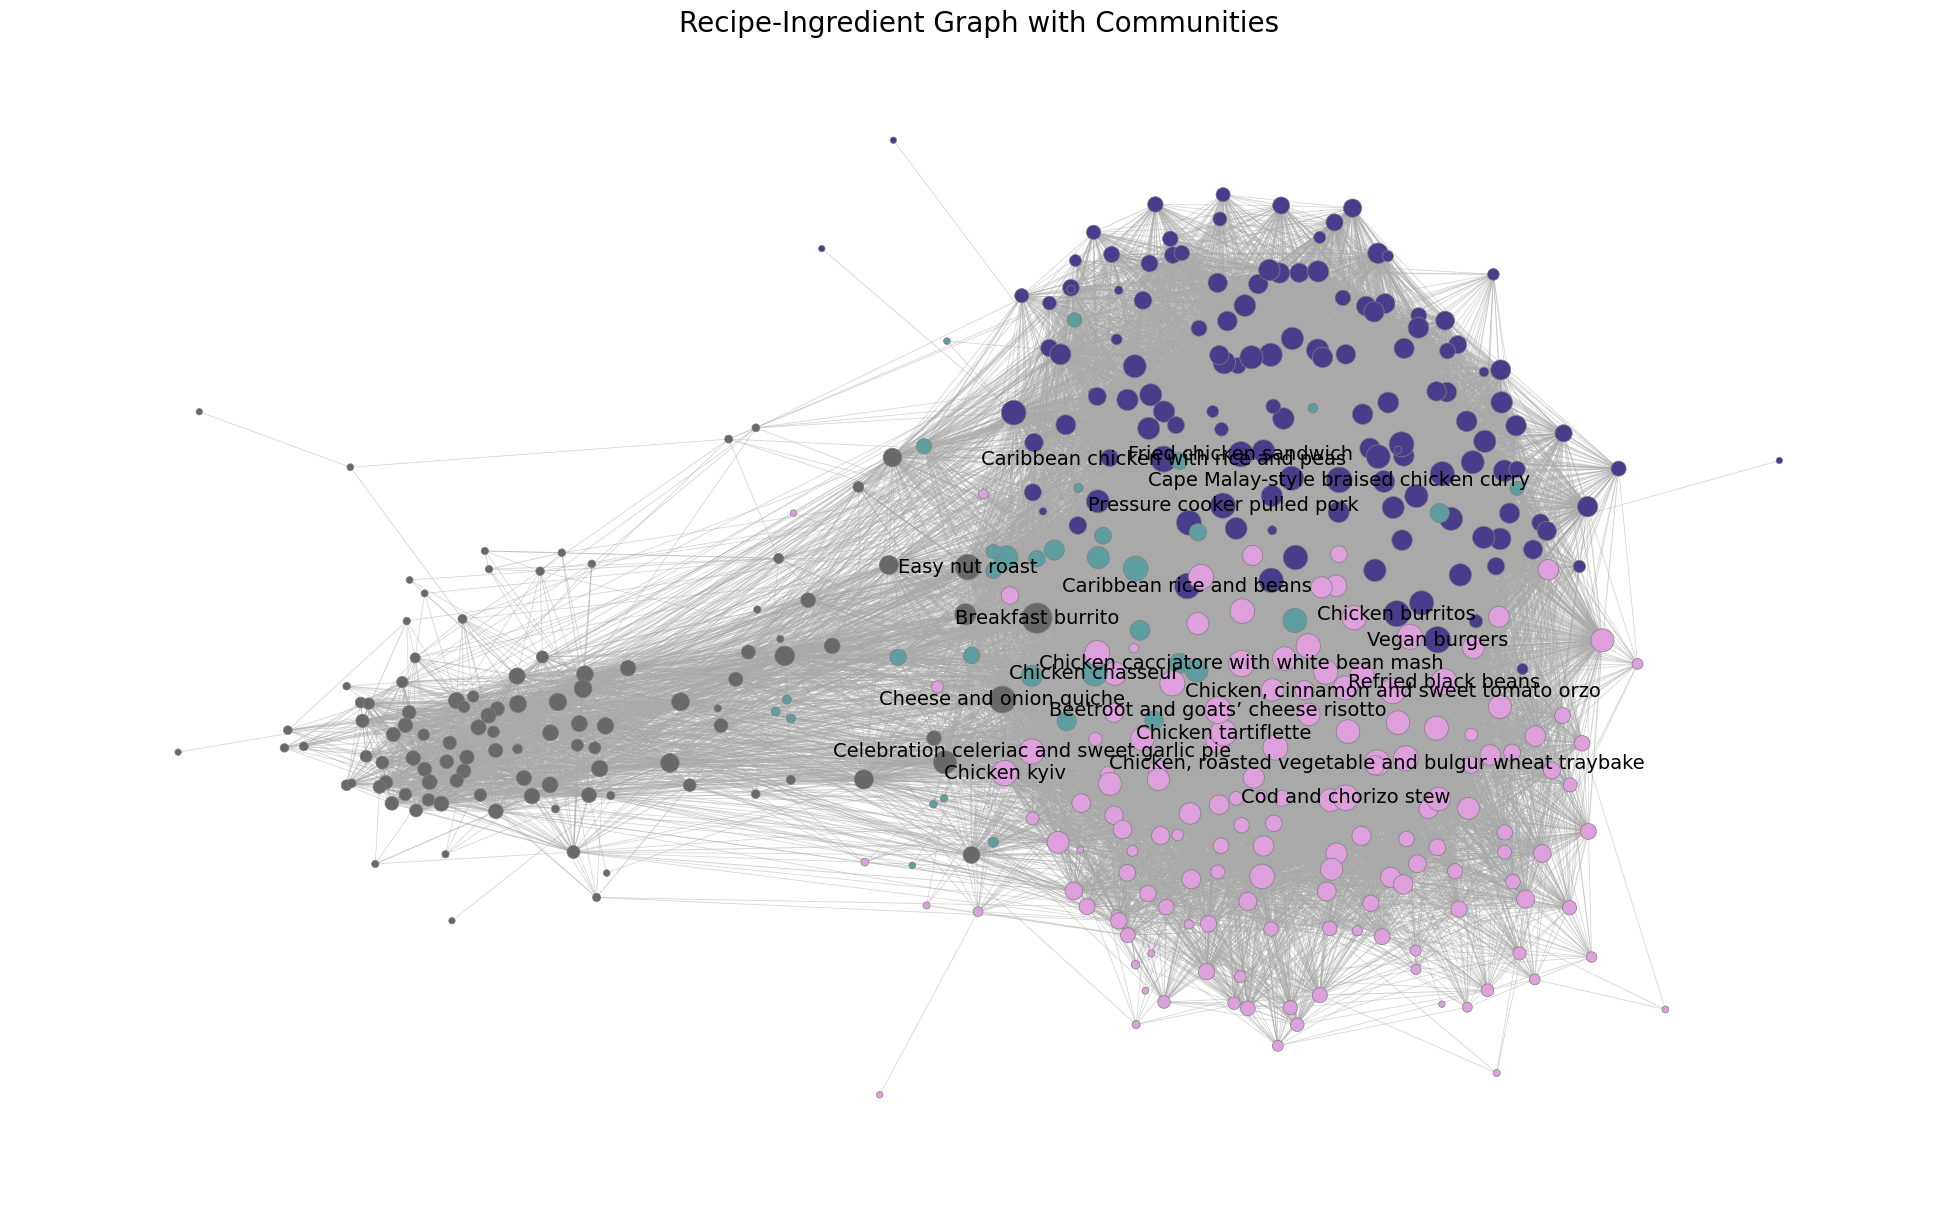

In [33]:
# Define custom colors for communities
community_colors = ['dimgrey', 'darkslateblue', 'plum', 'cadetblue']

# Map nodes to colors based on community
color_map = []
for node in G_recipes.nodes():
    for i, com in enumerate(louvainC):
        if node in com:
            # Use modulo in case there are more communities than colors
            color_map.append(community_colors[i % len(community_colors)])
            break

plt.figure(figsize=(25, 15))
pos = nx.forceatlas2_layout(G_recipes, max_iter=2000)

# --- Increase spacing between nodes ---
scale = 50  
pos = {node: (x * scale, y * scale) for node, (x, y) in pos.items()}

# Compute edge widths based on weight
edge_widths = np.array([d['weight'] for _, _, d in G_recipes.edges(data=True)])

# Make edges thinner & lighter
edge_widths = edge_widths / edge_widths.max() * 2.0  
nx.draw_networkx_edges(
    G_recipes, pos,
    width=edge_widths,
    edge_color="darkgrey",
    alpha=0.5
)

# Node sizes based on degree
degrees = dict(G_recipes.degree())
node_sizes = [degrees[node] * 1.5 + 20 for node in G_recipes.nodes()]


# Draw nodes with custom colors and border
nx.draw_networkx_nodes(G_recipes, pos, node_color=color_map, node_size=node_sizes, 
                       linewidths=0.5, edgecolors='grey')

# Only label the top nodes by degree
top_n = 20  
top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:top_n]
labels = {node: node for node, _ in top_nodes}

# Draw labels with smaller font
nx.draw_networkx_labels(G_recipes, pos, labels=labels, font_size=14)

plt.title("Recipe-Ingredient Graph with Communities", fontsize=20)
plt.axis("off")
plt.show()


In [34]:
# we map the communities with recipes
community_map = {}

for i, com in enumerate(louvainC):
    for title in com:
        community_map[title] = f"Community {i+1}"

data['community'] = data['title'].map(community_map)        

# Sentiment analysis

We conduct a sentiment analysis on all text components for each recipe

In [35]:
# sentiment analysis - happiness dataset to create score 
happiness_df = pd.read_csv("happiness_sentiment.txt", sep="\t")

In [36]:
# function to calculate sentiment score based on tokens
def sentiment(tokens, word_list = happiness_df):

    tokens = [token.lower() for token in tokens]

    token_series = pd.Series(tokens)
    token_freq = token_series.value_counts().reset_index()
    token_freq.columns = ['word', 'frequency']

    if token_freq.empty:
        return None
    
    words_in_list = word_list[word_list['word'].isin(tokens)]

    merged = pd.merge(token_freq, words_in_list, left_on='word', right_on='word')
    sentiment_score = sum(merged['frequency'] * merged['happiness_average'])/sum(merged['frequency'])
    
    return sentiment_score

In [37]:
# we want to calculate sentiment on both description,method,tags and overall
data['tokens_des'] = data['description'].str.split()
data['tokens_des'] = data['tokens_des'].apply(lambda x: [word for word in x if word.isalpha()])  
data['tokens_met'] = data['method'].str.split()
data['tokens_met'] = data['tokens_met'].apply(lambda x: [word for word in x if word.isalpha()])  
data['tokens_tag'] = data['tags'].str.split()
data['tokens_tag'] = data['tokens_tag'].apply(lambda x: [word for word in x if word.isalpha()])  
data['tokens_all'] = data.apply(lambda row: row['tokens_des'] + row['tokens_met'] + row['tokens_tag'],axis=1)
data['sentiment_des'] = data['tokens_des'].apply(lambda x: sentiment(x))
data['sentiment_met'] = data['tokens_met'].apply(lambda x: sentiment(x))
data['sentiment_tag'] = data['tokens_tag'].apply(lambda x: sentiment(x))
# Overall sentiment: 
data['sentiment_all'] = data['tokens_all'].apply(sentiment)
for idx, row in data.iterrows():
    if row['title'] in G_recipes.nodes:
        G_recipes.nodes[row['title']]['sentiment_des'] = row['sentiment_des']
        G_recipes.nodes[row['title']]['sentiment_met'] = row['sentiment_met']
        G_recipes.nodes[row['title']]['sentiment_tag'] = row['sentiment_tag']
        G_recipes.nodes[row['title']]['sentiment_all'] = row['sentiment_all']


In [38]:
# associate comumunities with sentiment scores
community_sentiments = []
for com in louvainC:
    com_sentiments_des = data[data['title'].isin(com)]['sentiment_des'].dropna()
    com_sentiments_met = data[data['title'].isin(com)]['sentiment_met'].dropna()
    com_sentiments_tag = data[data['title'].isin(com)]['sentiment_tag'].dropna()
    com_sentiments_all = data[data['title'].isin(com)]['sentiment_all'].dropna()
    if not com_sentiments_des.empty:
        avg_sentiment_des = com_sentiments_des.mean()
        avg_sentiment_met = com_sentiments_met.mean()
        avg_sentiment_tag = com_sentiments_tag.mean()
        avg_sentiment_all = com_sentiments_all.mean()
    else:
        avg_sentiment_des = None
        avg_sentiment_met = None
        avg_sentiment_tag = None
        avg_sentiment_all = None
    community_sentiments.append((com, avg_sentiment_des,avg_sentiment_met,avg_sentiment_tag,avg_sentiment_all))

for i, (com, avg_sentiment_des,avg_sentiment_met,avg_sentiment_tag,avg_sentiment_all) in enumerate(community_sentiments):
    print(f"Community {i+1} Average Sentiment for different textbits - descrip: {avg_sentiment_des} - method: {avg_sentiment_met} - tag: {avg_sentiment_tag} - overall: {avg_sentiment_all}")


Community 1 Average Sentiment for different textbits - descrip: 5.655111410213057 - method: 5.386920537871808 - tag: 6.602811521104359 - overall: 5.606230396946471
Community 2 Average Sentiment for different textbits - descrip: 5.576776143997168 - method: 5.3705793014163 - tag: 6.404740561101017 - overall: 5.5825110814202015
Community 3 Average Sentiment for different textbits - descrip: 5.610206089946646 - method: 5.371189474146832 - tag: 6.498899670061661 - overall: 5.630205537021756
Community 4 Average Sentiment for different textbits - descrip: 5.6068187985990665 - method: 5.354689304422151 - tag: 6.401913063153458 - overall: 5.542347454142866


## Box plots

We create box plots to gain insights on communities and their sentiment scores together with user rating

In [39]:
data_boxplot = data.copy()
data_boxplot['community'] = data_boxplot['title'].map(community_map)
data_boxplot = data_boxplot.dropna(subset=['community'])

# Variable names
types = ['sentiment_des', 'sentiment_met', 'sentiment_tag', 'ratingValue']

# Nice display names for subplot titles
titles = {
    'sentiment_des': 'Description Sentiment',
    'sentiment_met': 'Method Sentiment',
    'sentiment_tag': 'Tag Sentiment',
    'ratingValue': 'Rating'
}

# Create 2×2 subplot grid with tighter spacing
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=[titles[t] for t in types],
    horizontal_spacing=0.08,
    vertical_spacing=0.12
)

# Mapping from index to subplot position
positions = {0: (1, 1), 1: (1, 2), 2: (2, 1), 3: (2, 2)}

# Add one boxplot per subplot
for i, t in enumerate(types):
    row, col = positions[i]
    fig.add_trace(
        go.Box(x=data_boxplot['community'], y=data_boxplot[t], name=t),
        row=row, col=col
    )

fig.update_layout(
    height=900,
    width=1100,
    showlegend=False
)

fig.show()


## Outliers

We inspect the outliers

In [40]:
all_outlier_titles = set()
# choose from 'sentiment_tag', 'sentiment_met' , 'sentiment_des' , 'sentiment_all'
chosenSentType = 'sentiment_tag'
for i, com in enumerate(louvainC):
    community_name = f"Community {i+1}"

    # Filter data for this community
    com_data = data_boxplot[data_boxplot['community'] == community_name]

    if com_data.empty:
        print(f"{community_name} — No data found")
        continue

    # Compute IQR thresholds
    q1 = com_data[chosenSentType].quantile(0.25)
    q3 = com_data[chosenSentType].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Get outliers
    outliers = com_data[(com_data[chosenSentType] < lower_bound) | 
                        (com_data[chosenSentType] > upper_bound)]

    print(f"{community_name} Outliers:")
    print(outliers[['title', chosenSentType]])

    # Save the outlier titles
    all_outlier_titles.update(outliers['title'])


Community 1 Outliers:
             title  sentiment_tag
336  Bakewell tart       6.029333
Community 2 Outliers:
                  title  sentiment_tag
312  Budget beans pulao        5.81619
Community 3 Outliers:
          title  sentiment_tag
223  Fish cakes       5.951892
Community 4 Outliers:
Empty DataFrame
Columns: [title, sentiment_tag]
Index: []


### Visualization of outliers

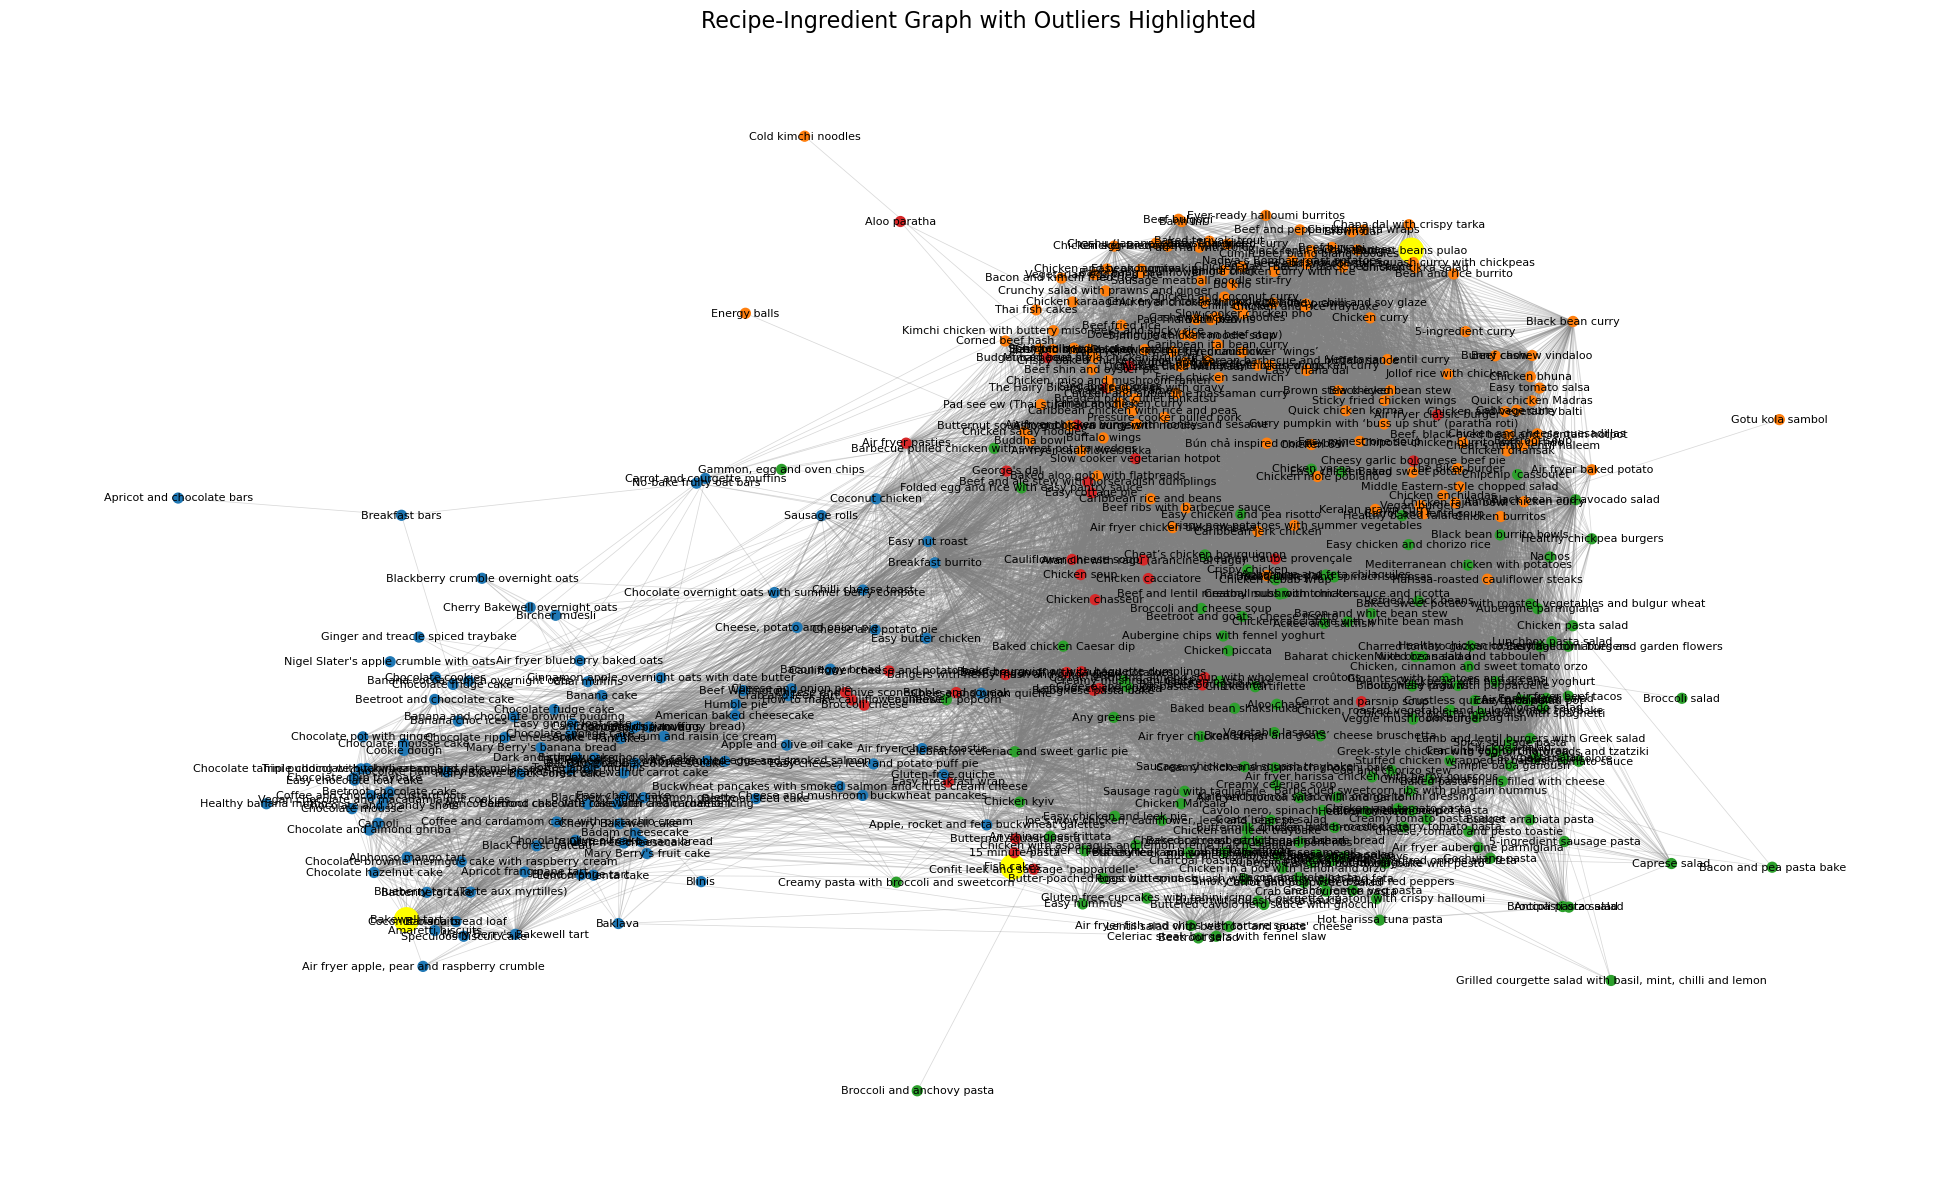

In [41]:
# create color map based on communities
color_map = []
node_sizes = []

for node in G_recipes.nodes():
    # check if node is an outlier first
    if node in all_outlier_titles:
        color_map.append('yellow')  # highlight outlier
        node_sizes.append(300)      # bigger node size
    else:
        # otherwise assign community color
        for i, com in enumerate(louvainC):
            if node in com:
                color_map.append(f'C{i}')
                node_sizes.append(50)   # normal size
                break

plt.figure(figsize=(25, 15))
pos = nx.forceatlas2_layout(G_recipes, max_iter=2000)

# draw nodes with colors and sizes
nx.draw_networkx_nodes(
    G_recipes,
    pos,
    node_color=color_map,
    node_size=node_sizes
)

# draw labels
nx.draw_networkx_labels(G_recipes, pos, font_size=8)

# compute edge widths based on weight
edge_widths = np.array([d['weight'] for _, _, d in G_recipes.edges(data=True)])
edge_widths = edge_widths / edge_widths.max() * 2  # normalize

# draw edges
nx.draw_networkx_edges(
    G_recipes,
    pos,
    width=edge_widths,
    edge_color="gray",
    alpha=0.3
)

plt.title("Recipe-Ingredient Graph with Outliers Highlighted", fontsize=16)
plt.axis("off")
plt.show()


## Analysis of sentiment and other measures

In [42]:
# Compute assortativity
r = nx.attribute_assortativity_coefficient(G_recipes, chosenSentType)
print(f"Assortativity (sentiment): {r:.5f}")

Assortativity (sentiment): -0.00353


In [43]:
data['community'] = data['title'].map(community_map)
df_plot = data.dropna(subset=['sentiment_des', 'ratingValue', 'community'])

fig = px.scatter(
    df_plot,
    x='sentiment_des',
    y='ratingValue',
    hover_name='title',
    color='community',  
    title='Sentiment vs RatingValue by Community',
    labels={
        'sentiment_des': 'Sentiment Score',
        'ratingValue': 'Rating',
        'community': 'Community'
    }
)
fig.show()


In [44]:

df_plot2 = data.dropna(subset=['degree', 'ratingValue', 'community'])

fig = px.scatter(
    df_plot2,
    x='degree',
    y='ratingValue',
    hover_name='title',
    color='community',  
    title='Node Degree vs RatingValue',
    labels={'degree': 'Node Degree', 'ratingValue': 'Rating',
        'community': 'Community'},
    #color_discrete_sequence=['orange']
)
fig.show()


This might look a bit confusing but the plots actually show that the vast majority of the recipes with low/medium sentiment and node degree are present in the entire range of the rating scale. however, even though only a fewer of the recipes have higher sentiment and node degree (share a lot of ingredients with others) it does look like these tend to also have higher rating! small conclusion: if i were to be a recipe author, i would try to post a recipe with high sentiment and "common" ingredients that share with a lot of the other recipes on that page? 

on the other hand, we cannot say much about those of lower sentiment and node degree... 

In [45]:
df_plot2 = data.dropna(subset=['ratingCount', chosenSentType])

fig = px.scatter(
    df_plot2,
    x='ratingCount',
    y=chosenSentType,
    hover_name='title',
    title='Rating count vs sentiment',
    labels={'ratingCount': 'RatingCount', chosenSentType: 'sentiment'},
    color_discrete_sequence=['orange']
)
fig.show()


## TF-IDF and Wordclouds

Using TF-IDF and wordclouds we are able to visualize the most prominent tokens among our communities

In [46]:
#prepare full text 
data['full_text'] = (
    data['description'].fillna('') + ' ' +
    data['method'].fillna('') + ' ' +
    data['tags'].fillna('')
)
# used to prepare text for tf-idf 
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

data['full_text_clean'] = data['full_text'].apply(clean_text)

# maps com and their respective texts
community_docs = {}

for i, com in enumerate(louvainC):
    members = list(com)
    texts = data[data["title"].isin(members)]["full_text_clean"].dropna().tolist()
    community_docs[f"Community_{i+1}"] = " ".join(texts)


In [47]:
# we now compute tf-idf using TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

communities_list = list(community_docs.keys())
docs_list = list(community_docs.values())

tfidf_matrix = vectorizer.fit_transform(docs_list)
feature_names = np.array(vectorizer.get_feature_names_out())


Common words across all communities: ['food', 'bowl', 'remove', 'using', 'brown', 'heat', 'recipes', 'water', 'egg', 'best', 'dairy', 'ingredients', 'nut', 'stir', 'mixture', 'gently', 'free', 'low', 'vegetarian', 'mix', 'fridge', 'recipe', 'add', 'just', 'day', 'air', 'bring', 'oven', 'pour', 'flour'] ...


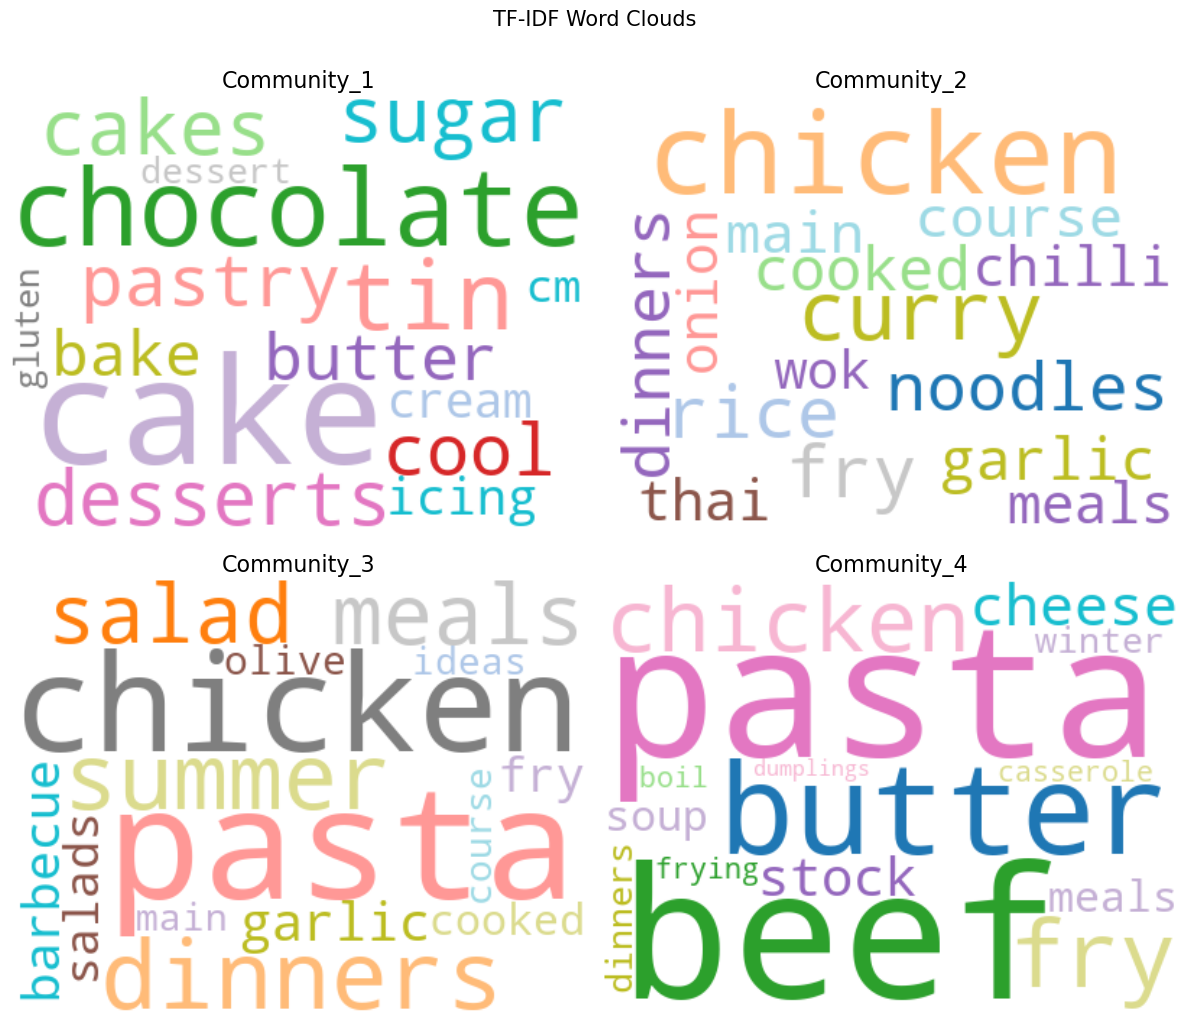

In [48]:
raw_words = {}
for i, comm in enumerate(communities_list):
    row = tfidf_matrix[i].toarray().flatten()
    idx = row.argsort()[::-1][:200]
    raw_words[comm] = set(feature_names[idx])

# Find words appearing in *all* communities

common_words = set.intersection(*raw_words.values())
print("Common words across all communities:", list(common_words)[:30], "...")

# extract common words per communitiy (15)
top_words_per_comm = {}
for i, comm in enumerate(communities_list):
    row = tfidf_matrix[i].toarray().flatten()
    idx_sorted = row.argsort()[::-1]

    filtered = [(feature_names[j], row[j]) 
                for j in idx_sorted 
                if feature_names[j] not in common_words] # if not in common words

    top_words_per_comm[comm] = filtered[:15]   # top 15 after filtering

# word cloud time 
n_comms = len(top_words_per_comm)
n_cols = 2
n_rows = int(np.ceil(n_comms / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()

for i, (comm, words) in enumerate(top_words_per_comm.items()):
    word_freq = dict(words)
    wc = WordCloud(
        width=400,
        height=300,
        background_color='white',
        colormap='tab20'
    ).generate_from_frequencies(word_freq)

    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(comm, fontsize=16)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("TF-IDF Word Clouds", fontsize=15, y=1.04)
plt.show()

